# DeepSurv-Breast-Prognosis
**Team:** ByteRunners

**Competition:** BioFusion Hackathon 2026

**Problem:** Predicting 5-Year Survival Risk in Breast Cancer Patients.

**Dataset:** METABRIC (Nature 2012), obtained from cBioPortal.

### 1: Installing Dependancies

In [ ]:
!pip install torch scikit-survival

### 2: Preparing the environment

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sksurv.metrics import concordance_index_censored

In [2]:
# ---------------------------------------------------------
# CELL 2: DATA LOADING & PREPROCESSING
# ---------------------------------------------------------

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sksurv.util import Surv

# Load METABRIC dataset
df = pd.read_csv('brca_metabric_clinical_data.tsv', sep='\t')

# Feature Selection: Selecting clinically relevant features for breast cancer prognosis.
# We also isolate 'Time' (survival months) and 'Event' (vital status) for the target.
cols_to_keep = [
    'Age at Diagnosis', 'Chemotherapy', 'Radiotherapy',
    'Tumor Size', 'Tumor Stage', 'Neoplasm Histologic Grade',
    'Lymph Nodes Examined Positive', 'Mutation Count', 'Nottingham Prognostic Index',
    'Overall Survival (Months)', 'Overall Survival Status' # TARGETS
]

existing_cols = [c for c in cols_to_keep if c in df.columns]
data = df[existing_cols].copy()

# Data Cleaning & Structuring
# 1. Drop rows with missing targets.
# 2. Convert Status to Boolean (Event = True/Dead, Censored = False/Living).
data = data.dropna(subset=['Overall Survival (Months)', 'Overall Survival Status'])
data['Event'] = data['Overall Survival Status'].astype(str).apply(lambda x: True if 'DECEASED' in x.upper() else False)
data['Time'] = data['Overall Survival (Months)']

# Preprocessing Features
# - Impute missing numerical values with median.
# - One-Hot Encode categorical variables for the Random Forest.
X = data.drop(['Overall Survival (Months)', 'Overall Survival Status', 'Event', 'Time'], axis=1)
num_cols = X.select_dtypes(include=np.number).columns
if len(num_cols) > 0:
    imp_num = SimpleImputer(strategy='median')
    X[num_cols] = imp_num.fit_transform(X[num_cols])
X = pd.get_dummies(X, drop_first=True)

# Constructing the Target Array
# scikit-survival requires a structured array of (Event, Time) tuples.
y = Surv.from_arrays(event=data['Event'].values, time=data['Time'].values)

print(f"Processed Data: {X.shape[0]} samples, {X.shape[1]} features.")
print("Target format example:", y[:5])

Processed Data: 1981 samples, 6 features.
Target format example: [(False, 140.5       ) (False,  84.63333333) ( True, 163.7       )
 (False, 164.93333333) ( True,  41.36666667)]


In [3]:
# ---------------------------------------------------------
# CELL 3: PREPARE DATA FOR PYTORCH
# ---------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert Data to PyTorch Tensors
# PyTorch requires float32 tensors for the neural network.
X_train_tensor = torch.tensor(X_train.values.astype(np.float32), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values.astype(np.float32), dtype=torch.float32)

# Unpacking the Target
# DeepSurv requires separate Tensors for 'Time' and 'Event', not a structured array.
def get_target_tensor(y_struct):
    events = torch.tensor([x[0] for x in y_struct], dtype=torch.float32).unsqueeze(1)
    times = torch.tensor([x[1] for x in y_struct], dtype=torch.float32).unsqueeze(1)
    return times, events

train_times, train_events = get_target_tensor(y_train)
test_times, test_events = get_target_tensor(y_test)

In [4]:
class DeepSurv(nn.Module):
    def __init__(self, input_dim):
        super(DeepSurv, self).__init__()
        # 3-Layer Perceptron with Dropout to prevent overfitting
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64), # Batch Norm helps convergence
            nn.Dropout(0.4),    # Critical for small medical datasets

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.4),

            nn.Linear(32, 1),   # Output is a single "Risk Score"
            nn.Tanh()           # Tanh often stabilizes survival outputs
        )

    def forward(self, x):
        return self.network(x)

In [5]:
def cox_loss(risk_scores, times, events):
    # Cox Partial Likelihood Loss
    # We want to maximize the probability that the patient who died had a higher risk score 
    # than all other patients who were alive at that time (the "Risk Set").
    
    # 1. Sort by time (descending) to easily compute the Risk Set
    idx = times.sort(dim=0, descending=True)[1].squeeze()
    risk_scores = risk_scores[idx]
    events = events[idx]

    # 2. Compute Log-Sum-Exp of risk scores (The "Risk Set" denominator)
    # cumsum allows us to efficiently calculate the sum of risks for everyone 'at risk'
    exp_scores = torch.exp(risk_scores)
    risk_set_sum = torch.cumsum(exp_scores, dim=0) 
    
    # 3. Calculate Log-Likelihood
    # log(risk / sum(risk_at_risk)) = log(risk) - log(sum(risk_at_risk))
    log_likelihood = risk_scores - torch.log(risk_set_sum + 1e-5) # 1e-5 for stability
    
    # 4. Negate because we want to Minimize Loss (Maximize Likelihood)
    # Only events (deaths) contribute to the loss numerator.
    loss = -torch.mean(log_likelihood * events)
    return loss

Starting Deep Learning Training Loop...
Epoch 0: Loss = 3.8948
Epoch 20: Loss = 3.7671
Epoch 40: Loss = 3.7617
Epoch 60: Loss = 3.7542
Epoch 80: Loss = 3.7471
Epoch 100: Loss = 3.7396
Epoch 120: Loss = 3.7413
Epoch 140: Loss = 3.7466
Epoch 160: Loss = 3.7263
Epoch 180: Loss = 3.7342


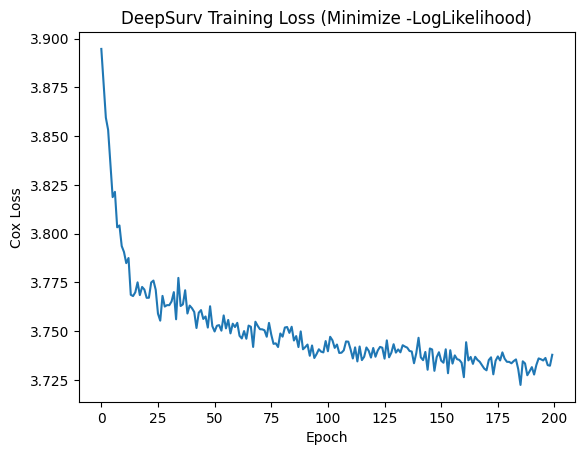

In [6]:
model = DeepSurv(X_train_tensor.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) # L2 Regularization

epochs = 200
train_losses = []

print("Starting Deep Learning Training Loop...")
for epoch in range(epochs):
    model.train()
    
    # 1. Forward Pass: Predict Risk Scores
    risk_pred = model(X_train_tensor)
    
    # 2. Calculate Cox Loss
    loss = cox_loss(risk_pred, train_times, train_events)
    
    # 3. Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

# Visualize Convergence
plt.plot(train_losses)
plt.title("DeepSurv Training Loss (Minimize -LogLikelihood)")
plt.xlabel("Epoch")
plt.ylabel("Cox Loss")
plt.show()

### 8: Evaluation

In [7]:
model.eval()
with torch.no_grad():
    test_risk = model(X_test_tensor).numpy()

# C-Index (Note: Higher risk score = Shorter survival time)
# sksurv expects risk scores where higher = *shorter* survival (hazard)
c_index = concordance_index_censored(test_events.squeeze().bool().numpy(), test_times.squeeze().numpy(), test_risk.squeeze())

print(f"\n DeepSurv C-Index: {c_index[0]:.4f}")


 DeepSurv C-Index: 0.6521
